## imports

In [1]:
import sys
import os
import h5py
import pickle

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Invoking __init__.py for NDNT.utils
Save_dir = ./Monocular/


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


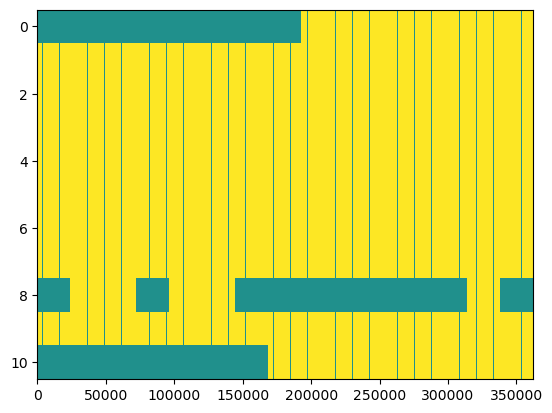

In [2]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

In [3]:
# create ADAM params
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [4]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [7]:
num_subs = [8, 8, 4]
fws = [21, 9, 9]
XTregB = 0.0001
Greg = 0.001
Creg= None
clayers = []
for ii in range(0,len(num_subs)):
    clayers.append(
        ConvLayer.layer_dict(
            num_filters=num_subs[ii], bias=False, norm_type=1, num_inh=num_subs[ii]//2,
            filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
    clayers[ii]['output_norm'] = 'batch'
    clayers[ii]['window'] = 'hamming'
clayers[0]['input_dims'] = data.stim_dims
clayers[0]['reg_vals'] = {'d2xt': XTregB, 'center': Creg, 'bcs':{'d2xt':1} }

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold',
    xstim_n = 'stim', layer_list = clayers )

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True,
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  }

readout_net = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_par], ffnet_type='normal')

cnn = NDN.NDN( ffnet_list=[scaffold_net, readout_net] )
cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([72, 8])
  Layer 2:
      weight: torch.Size([72, 4])
Network 1:
  Layer 0:
      weight: torch.Size([720, 11])
      bias: torch.Size([11])


In [8]:
#cnn.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
#LLs1 = cnn.eval_models(val_ds, null_adjusted=True)
#print(LLs1, np.mean(LLs1))

#with open('cnn1.pickle', 'wb') as f:
#    pickle.dump(cnn, f)

with open('cnn1.pickle', 'rb') as f:
    cnn = pickle.load(f)


GPU Available: True, GPU Used: True


Validating ver=4: 100%|████████████████████████| 35/35 [00:00<00:00, 46.95it/s, val_loss=0.414]


Early stopping
Done fitting
  Fit complete: 63.78055810928345 sec elapsed


Eval models: 100%|█████████████████████████████████████████████| 69/69 [00:00<00:00, 99.28it/s]


[ 0.5526042   0.640593    1.0906146   0.28850913  0.42516482 -0.00697494
  0.06694365  0.09494638 -0.04503679  0.61552846  0.12202668] 0.34953812


NameError: name 'pickle' is not defined

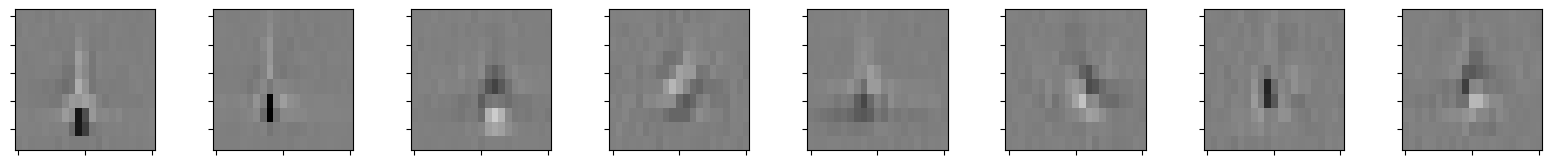

In [13]:
cnn.plot_filters()

In [14]:
# R2
#m.fig()
#plt.bar(range(11), met.r2(data, cnn0))
#plt.show()

cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([72, 8])
  Layer 2:
      weight: torch.Size([72, 4])
Network 1:
  Layer 0:
      weight: torch.Size([720, 11])
      bias: torch.Size([11])


In [25]:
# plot using cool plotting code
print(len(cnn.networks), len(cnn.networks[0].layers), len(cnn.networks[1].layers))

# get the convolutional filters
hidden0 = cnn.networks[0].layers[0].get_weights()
hidden1 = cnn.networks[0].layers[1].get_weights()
hidden2 = cnn.networks[0].layers[2].get_weights()
output0 = cnn.networks[1].layers[0].get_weights()

print(hidden0.shape, '-->',
      hidden1.shape, '-->',
      hidden2.shape, '-->',
      output0.shape)

2 3 1
(21, 10, 8) --> (8, 9, 8) --> (8, 9, 4) --> (20, 36, 11)


In [ ]:
# reshape layers





# hidden layer reshaped to be a list of 8 boxes
# (21, 10, 8) --> (8, 10, 21)
hidden_boxes = np.swapaxes(hidden, 0,2)
# sums of the weights of each neuron
# (8, 38, 11) --> (36, 11) --> (1, 36, 11)
output_sums = np.expand_dims(np.sum(output, axis=0), 1)
output_sums = np.swapaxes(output_sums, 0,2)

print(output.shape, hidden_boxes.shape, output_sums.shape)

output[:,0,0][output[:,0,0]<0]

print(output.shape)

# normalize the data we are giving the plot
# preserve dimensionality
# https://stackoverflow.com/questions/29046162/numpy-array-loss-of-dimension-when-masking
posnorm = np.where(hidden_boxes>=0, hidden_boxes, 0) / np.max(hidden_boxes[hidden_boxes>=0])
negnorm = np.where(hidden_boxes<0, hidden_boxes, 0) / np.abs(np.min(hidden_boxes[hidden_boxes<0]))
hidden_boxes_normalized = posnorm + negnorm

print(np.min(hidden_boxes_normalized), np.max(hidden_boxes_normalized))
print(hidden_boxes_normalized.shape, output_sums.shape)

In [35]:
def print_layers(layers):
    for i, layer in enumerate(layers):
        if i < len(layers)-1: # print with trailing arrow if it is not the last one
            print(layer.shape, end=" --> ")
        else: # print without trailing arrow
            print(layer.shape)

def get_layers(model):
    layers = []
    for n in range(len(model.networks)): # iterate over networks
        for l in range(len(model.networks[n].layers)): # iterate over layers for that network
            layers.append(model.networks[n].layers[l].get_weights())
    return layers

# test get_layers(model)
layers = get_layers(cnn)
print_layers(layers)

(21, 10, 8) --> (8, 9, 8) --> (8, 9, 4) --> (20, 36, 11)


In [46]:
def make_layers(model):
    output = []
    
    # get the layers from the model
    layers = get_layers(model)
    print_layers(layers)
    
    # for the 1D CNN we are using
    # first layer is (width, height, num)
    output.append(np.swapaxes(layers[0], 0,2))
    
    # further layers are (back_weights, width, num)
    for layer in layers[1:]:
        layer_sums = np.expand_dims(np.sum(layer, axis=0), 1)
        layer_sums = np.swapaxes(layer_sums, 0,2)
        output.append(layer_sums)
    
    # reshape the layers to make them drawable
    
    
    # normalize the layers to make them between -1 and 1
    
    return output

print_layers(make_layers(cnn))

(21, 10, 8) --> (8, 9, 8) --> (8, 9, 4) --> (20, 36, 11)
(8, 10, 21) --> (8, 1, 9) --> (4, 1, 9) --> (11, 1, 36)


In [ ]:
# create weights

col_idx = 1680 # terrible hack
weights = {}
# create the edge dictionary per neuron
for c in range(output.shape[2]): # for each neuron
    for col in range(output.shape[1]): # for each column in the neuron
        i = 0 # start the id
        weights[col_idx] = {}
        #print(col_idx)
        # normalize output
        max_weight = np.max(output[:,col,c])
        if max_weight == 0:
                max_weight = 1
        posnorm = output[:,col,c] / max_weight
        # there is no negative value b/c we put pos constraint, need to more automagically account for this
        #negnorm = np.where(output[:,col,c]<0, output[:,col,c], 0) / np.abs(np.min(output[:,col,c][output[:,col,c]<0]))
        output_normalized = posnorm
        #print(output_normalized.shape, np.min(output_normalized), np.max(output_normalized))
        for b, w in enumerate(output_normalized): # for each box & its weight
            for row in range(hidden_boxes[b,:,:].shape[0]): # for each row in the box
                for row in range(hidden_boxes[b,:,:].shape[1]): # for each col in that row
                    weights[col_idx][i] = w
                    i += 1
        col_idx += 1
                
#print(weights.keys())
print(np.sum(hidden_boxes), np.sum(output_sums))

In [27]:
def make_weights():
    # create the weights between adjacent layers
    
    ...

In [48]:
# call make_layers() and make_weights()
layers = make_layers(cnn)
print_layers(layers)

(21, 10, 8) --> (8, 9, 8) --> (8, 9, 4) --> (20, 36, 11)
(8, 10, 21) --> (8, 1, 9) --> (4, 1, 9) --> (11, 1, 36)


In [41]:
from IPython.display import display, Javascript, HTML
import json

def draw_grids(data, edges, width, layer_heights, layer_dims, padding, layer_padding):
    display(Javascript("""
        (function(element){
            require(['grids'], function(grids) {
                grids(element.get(0), %s, %s, %d, %s, %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), edges, width, layer_heights, layer_dims, padding, layer_padding)))

In [64]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))
# the layers to display
draw_grids([layer.tolist() for layer in layers],
           {},
           width=800,
           layer_heights={0:200, 1:100, 2:50, 3:200},
           layer_dims={0:{'rows':2, 'cols':4}, 
                       1:{'rows':2, 'cols':4},
                       2:{'rows':1, 'cols':4},
                       3:{'rows':4, 'cols':3}},
           padding=5,
           layer_padding=20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>